In [1]:
import numpy as np
import pandas as pd
# from tkinter import filedialog as fd
# from rdkit import Chem, DataStructs, RDLogger
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw, Descriptors, AllChem
# from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# IPythonConsole.ipython_useSVG=True

# import numpy as np
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
import joblib


import MachineLearning as ML

In [2]:
smiles = pd.read_csv('tested_molecules-1.csv')
smiles = smiles['SMILES']

In [3]:
allAHDL1inhibitors = ML.importFiles(nrFiles=2)
ML.writeNewMolfile(allAHDL1inhibitors)

2023-06-19 15:50:02.319 python[42224:1993816] +[CATransaction synchronize] called within transaction
2023-06-19 15:50:02.578 python[42224:1993816] +[CATransaction synchronize] called within transaction
2023-06-19 15:50:05.709 python[42224:1993816] +[CATransaction synchronize] called within transaction
2023-06-19 15:50:05.930 python[42224:1993816] +[CATransaction synchronize] called within transaction


All molecules stored in: AllTestedMols.txt


In [4]:
allDescrs = ML.createDescriptorDf()
# allDescrs = allDescrs.drop(columns=["SMILES"])
x = ML.generateMorganFingerprint()
y = allAHDL1inhibitors[1][1:].astype(int)
sum(y)/len(y)
x, xDims = ML.CombineDescriptorsAndFigerprints(x,allDescrs)

In [38]:
xScale = ML.scaleData(x,scaletype='standardize')

xPrep, _ = ML.PCAfeatureReduction(xScale, 0.9)
# xPrep = xScale

# splitting is stil done due to the  seed, data is split the same as
# in training so model still sees unseen samples (default: seed =13)
xTrain, xTest, yTrain, yTest, cv = ML.splitTrainTestData(xPrep,y,
                                                         printSplit=True)




Fold_1
TRAIN: [   0    1    2 ... 1597 1598 1599]
TEST: [   6   16   23   26   32   34   35   36   37   39   40   41   42   43
   48   53   55   59   63   67   71   84   87   94   98  110  119  123
  129  131  135  139  141  142  155  162  164  170  177  184  186  187
  192  200  204  205  210  214  218  233  236  240  242  261  263  288
  292  297  299  308  316  318  321  323  329  348  349  352  355  363
  367  373  377  385  387  390  392  393  396  397  406  408  414  423
  425  436  439  442  449  457  458  460  461  462  464  467  470  471
  476  483  484  492  503  504  507  510  522  523  528  539  540  546
  554  558  562  576  584  586  590  594  604  605  607  609  614  615
  626  628  635  642  648  652  656  663  665  680  681  683  687  692
  702  709  710  716  729  732  739  742  743  745  746  750  753  761
  766  768  774  777  780  798  813  826  839  840  842  847  848  859
  864  873  877  881  893  895  899  901  904  909  910  913  915  922
  925  927  928  930

In [39]:
# model in this case is the trained model 

# trainedModel = joblib.load(f"RandomForestClassifier_PCA1_std.pkl")

if 'SMILES' in xTest:
    xTest = xTest.drop(columns=["SMILES"])


pred, balAcc, evaluationReport, confusionMatrix, predProb = ML.testTrainedModel(xTest, yTest, model=None, 
                                              savedModelfilename="SupportVectorClassifier_PCA90_norm.pkl",
                                              scaledData=True, 
                                              scaledDatafile=None)
print(pred,'\n', 'Balanced Accuracy:  ', balAcc,'\n', evaluationReport, '\n', confusionMatrix, '\n', predProb)


/Users/timstassen/opt/anaconda3/envs/rdkit/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: X has 807 features, but SVC is expecting 536 features as input.

## For plotting

In [10]:
xTrain.columns = xTrain.columns.astype(str)
xTrain = xTrain.drop(columns=["SMILES"])
RFmodel, bestParam, RFgrid, param_grid, BestScoreRFgrid = ML.trainRF(xTrain, yTrain, cv)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best Random Forest Classifier: 
 Parameters: {'max_features': 752, 'n_estimators': 500} 
 balanced accuracy:  0.7501581552586615


In [11]:
from sklearn import neighbors, metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

scorer = metrics.make_scorer(metrics.balanced_accuracy_score)
RFc = RandomForestClassifier()
param_grid = {"max_features": [xTrain.shape[1] // 10, xTrain.shape[1] // 7, 
                               xTrain.shape[1] // 5, xTrain.shape[1] // 3], 
                  "n_estimators": [100, 250, 500]}
RFgrid = GridSearchCV(RFc, param_grid, scoring=scorer, error_score="raise",
                           return_train_score=True, n_jobs=2, cv=cv, verbose=1)
    

NameError: name 'X' is not defined

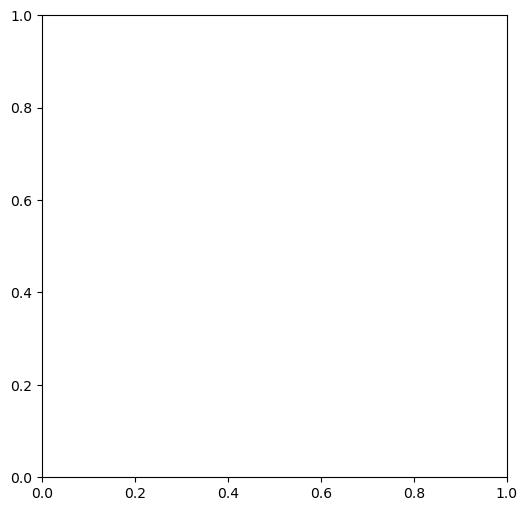

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(x, y)):
    RFc.fit(xTrain, yTest[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()